# 0. Problem statement
In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is to build a machine learning model that is able to predict churning customers based on the features provided for their usage.

### Customer behaviour during churn:

Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, we assume that there are three phases of customer lifecycle :

1. The ‘good’ phase: In this phase, the customer is happy with the service and behaves as usual.

2. The ‘action’ phase: The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. The ‘churn’ phase: In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

# 1. Loading dependencies & datasets

In [1]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os


import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score

#For Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

pd.set_option('display.max_colwidth', None) #to configure pandas to display values without any truncation.


In [2]:
#Loading CSV files

data = pd.read_csv("train.csv")
unseen = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")

print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


In [3]:
data_dict

,Acronyms,Description
0,CIRCLE_ID,Telecom circle area to which the customer belongs to
1,LOC,Local calls within same telecom circle
2,STD,STD calls outside the calling circle
3,IC,Incoming calls
4,OG,Outgoing calls
5,T2T,Operator T to T ie within same operator mobile to mobile
6,T2M,Operator T to other operator mobile
7,T2O,Operator T to other operator fixed line
8,T2F,Operator T to fixed lines of T
9,T2C,Operator T to its own call center


In [4]:
ids = ['id','circle_id']
total_amounts = [i for i in list(data.columns) if re.search('total.+amt',i)]
total_outgoing_minutes = [i for i in list(data.columns) if re.search('total.+og.+mou',i)]
offnetwork_minutes = [i for i in list(data.columns) if re.search('offnet',i)]
average_revenue_3g = [i for i in list(data.columns) if re.search('arpu.+3g',i)]
average_revenue_2g = [i for i in list(data.columns) if re.search('arpu.+2g',i)]
volume_3g = [i for i in list(data.columns) if re.search('vol.+3g',i)]
volume_2g = [i for i in list(data.columns) if re.search('vol.+2g',i)]
age_on_network = [i for i in list(data.columns) if re.search('aon',i)]

#Storing them in a single flat list
variables = [*ids, 
             *total_amounts, 
             *total_outgoing_minutes, 
             *offnetwork_minutes, 
             *average_revenue_3g, 
             *average_revenue_2g,
             *volume_3g,
             *volume_2g,
             *age_on_network, 
             'churn_probability']

data = data[variables].set_index('id')

In [5]:
data.head()

,circle_id,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,arpu_2g_7,arpu_2g_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon,churn_probability
id,,,,,,,,,,,,,,,,,,,,,
0,109,77,65,10,81.21,221.68,3.63,32.24,96.68,2.33,...,NaN,NaN,0.0,0.00,0.0,0.0,0.00,0.00,1958,0
1,109,0,145,50,0.00,30.73,31.66,0.00,25.99,30.89,...,122.08,NaN,0.0,3.96,0.0,0.0,352.91,0.00,710,0
2,109,70,120,0,56.49,99.36,0.00,53.99,82.05,0.00,...,NaN,NaN,0.0,0.00,0.0,0.0,0.00,0.00,882,0
3,109,160,240,130,76.03,95.98,53.84,68.76,78.48,50.23,...,NaN,NaN,0.0,0.00,0.0,0.0,0.00,0.00,982,0
4,109,290,136,122,63.26,42.94,15.76,56.99,38.11,9.63,...,35.12,0.0,0.0,0.00,0.0,390.8,308.89,213.47,647,0


In [6]:
data.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69999 entries, 0 to 69998
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   circle_id          69999 non-null  int64  
 1   total_rech_amt_6   69999 non-null  int64  
 2   total_rech_amt_7   69999 non-null  int64  
 3   total_rech_amt_8   69999 non-null  int64  
 4   total_og_mou_6     69999 non-null  float64
 5   total_og_mou_7     69999 non-null  float64
 6   total_og_mou_8     69999 non-null  float64
 7   offnet_mou_6       67231 non-null  float64
 8   offnet_mou_7       67312 non-null  float64
 9   offnet_mou_8       66296 non-null  float64
 10  arpu_3g_6          17568 non-null  float64
 11  arpu_3g_7          17865 non-null  float64
 12  arpu_3g_8          18417 non-null  float64
 13  arpu_2g_6          17568 non-null  float64
 14  arpu_2g_7          17865 non-null  float64
 15  arpu_2g_8          18417 non-null  float64
 16  vol_3g_mb_6        699

In [7]:
data.describe(include="all")

,circle_id,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,arpu_2g_7,arpu_2g_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon,churn_probability
count,69999.0,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,...,17865.000000,18417.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000
mean,109.0,328.139788,322.376363,323.846355,306.451436,310.572674,304.513065,198.874771,197.153383,196.543577,...,85.846074,86.348404,122.171882,128.934444,135.486541,51.773924,51.240204,50.127506,1220.639709,0.101887
std,0.0,404.211068,411.070120,426.181405,465.502866,479.131770,477.936832,316.818355,322.482226,324.089234,...,178.067280,170.297094,554.869965,554.096072,568.310234,212.513909,211.114667,213.101403,952.426321,0.302502
min,109.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-13.090000,-55.830000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000
25%,109.0,110.000000,100.000000,90.000000,44.780000,42.910000,38.710000,34.860000,32.240000,31.575000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,468.000000,0.000000
50%,109.0,229.000000,220.000000,225.000000,145.280000,141.230000,138.360000,96.480000,91.885000,91.800000,...,8.800000,9.090000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,868.000000,0.000000
75%,109.0,438.000000,430.000000,436.000000,374.305000,380.045000,370.895000,232.990000,227.630000,229.345000,...,122.070000,122.070000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1813.000000,0.000000
max,109.0,35190.000000,40335.000000,45320.000000,10674.030000,8285.640000,14043.060000,8362.360000,7043.980000,14007.340000,...,4809.360000,3483.170000,45735.400000,28144.120000,30036.060000,10285.900000,7873.550000,11117.610000,4337.000000,1.000000


# 2. Create X, y and then Train test split¶

In [8]:
data['circle_id'].unique()

array([109], dtype=int64)

In [9]:
X = data.drop(['circle_id'],1).iloc[:,:-1]
y = data.iloc[:,-1]

In [10]:
X.shape, y.shape

((69999, 22), (69999,))

Splitting train and test data to avoid any contamination of the test data

In [11]:
#Splitting train and test data to avoid any contamination of the test data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((55999, 22), (14000, 22), (55999,), (14000,))

In [12]:
X_train.head()

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,arpu_3g_6,...,arpu_2g_6,arpu_2g_7,arpu_2g_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon
id,,,,,,,,,,,,,,,,,,,,,
30676,301,260,300,306.23,260.76,267.18,274.71,218.68,213.14,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,0.00,0.0,0.00,205
10038,513,363,323,731.68,602.03,402.39,483.64,259.33,178.68,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,0.00,0.0,0.00,790
49517,344,239,78,125.08,161.73,100.64,97.04,137.64,58.23,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,0.00,0.0,0.00,550
14362,138,0,92,2.20,0.00,0.00,12.24,1.68,3.40,0.0,...,31.65,NaN,0.0,0.0,0.0,0.0,761.91,0.0,448.25,352
34545,350,70,0,440.06,100.83,0.00,9.23,1.33,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,0.00,0.0,0.00,183


# 3. Handling Missing data¶
* First lets analyse the missing data. We can use missingno library for quick visualizations.

<AxesSubplot:>

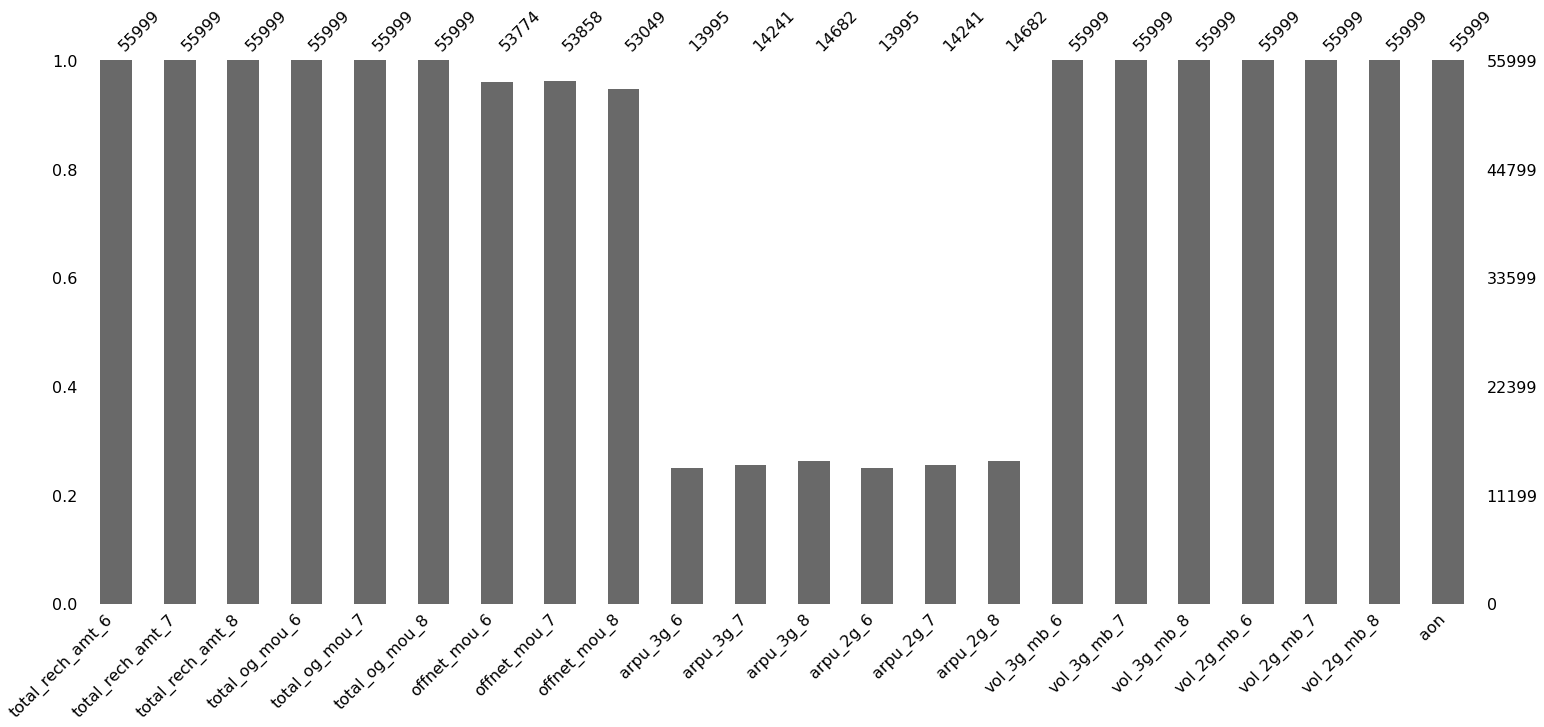

In [13]:
msno.bar(X_train)

<AxesSubplot:>

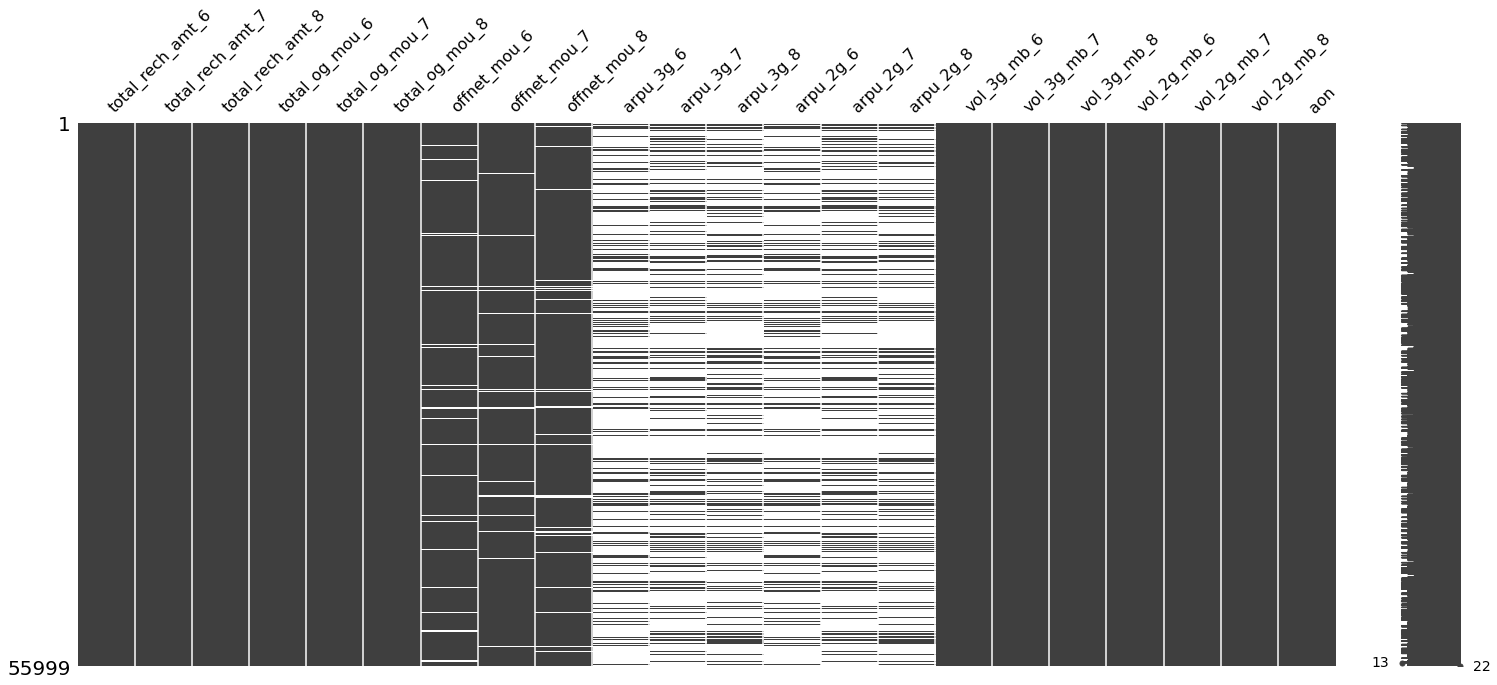

In [14]:
msno.matrix(X_train)

In [15]:
missing_data_percent = 100*X_train.isnull().sum()/len(y_train)
missing_data_percent

total_rech_amt_6     0.000000
total_rech_amt_7     0.000000
total_rech_amt_8     0.000000
total_og_mou_6       0.000000
total_og_mou_7       0.000000
total_og_mou_8       0.000000
offnet_mou_6         3.973285
offnet_mou_7         3.823283
offnet_mou_8         5.267951
arpu_3g_6           75.008482
arpu_3g_7           74.569189
arpu_3g_8           73.781675
arpu_2g_6           75.008482
arpu_2g_7           74.569189
arpu_2g_8           73.781675
vol_3g_mb_6          0.000000
vol_3g_mb_7          0.000000
vol_3g_mb_8          0.000000
vol_2g_mb_6          0.000000
vol_2g_mb_7          0.000000
vol_2g_mb_8          0.000000
aon                  0.000000
dtype: float64

Since too much missing information would make a column like arpu_3g and arpu_2g not really a great predictor for churn, we drop these columns and keep only the ones which have less than 40% missing data and impute the remaining missing values.

In [16]:
new_vars = missing_data_percent[missing_data_percent.le(40)].index
new_vars

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'vol_3g_mb_6', 'vol_3g_mb_7',
       'vol_3g_mb_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'aon'],
      dtype='object')

In [17]:
X_train_filtered = X_train[new_vars]
X_train_filtered.shape

(55999, 16)

In [18]:
missing_data_percent = X_train_filtered.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols

Index(['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8'], dtype='object')

In [19]:
imp = SimpleImputer(strategy='constant', fill_value=0)
X_train_filtered[impute_cols] = imp.fit_transform(X_train_filtered[impute_cols])

# 4. Exploratory Data Analysis & Preprocessing¶
Lets start by analysing the univariate distributions of each feature.

<AxesSubplot:>

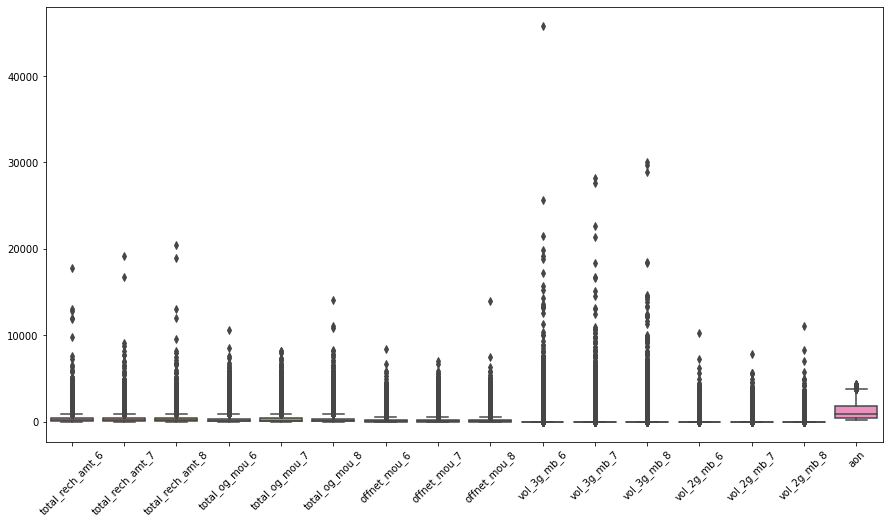

In [20]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered)

## _4.1 Handling outliers¶_
The box plots of these features show there a lot of outliers. These can be capped with k-sigma method.

The term "three-sigma" points to three standard deviations. Three-sigma limits set a range for the process parameter at 0.27% control limits. Three-sigma control limits are used to check data from a process and if it is within statistical control. This is done by checking if data points are within three standard deviations from the mean. The upper control limit (UCL) is set three-sigma levels above the mean, and the lower control limit (LCL) is set at three sigma levels below the mean.

- Three-sigma limits (3-sigma limits) is a statistical calculation that refers to data within three standard deviations from a mean.
- Three-sigma limits are used to set the upper and lower control limits in statistical quality control charts.
- On a bell curve, data that lie above the average and beyond the three-sigma line represent less than 1% of all data points.

In [21]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

<AxesSubplot:>

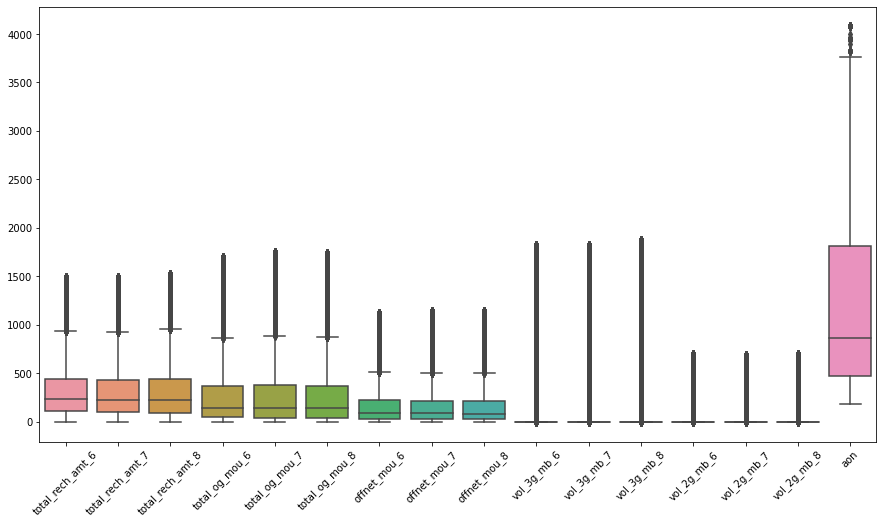

In [22]:
X_train_filtered1 = X_train_filtered.apply(cap_outliers, axis=0)

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered1)

## 4.2 Feature scaling
Lets also scale thefeatures by scaling them with 
Standard scaler (few other alternates are min-max scaling and Z-scaling).

In [23]:
scale = StandardScaler()
X_train_filtered2 = scale.fit_transform(X_train_filtered1)

<AxesSubplot:>

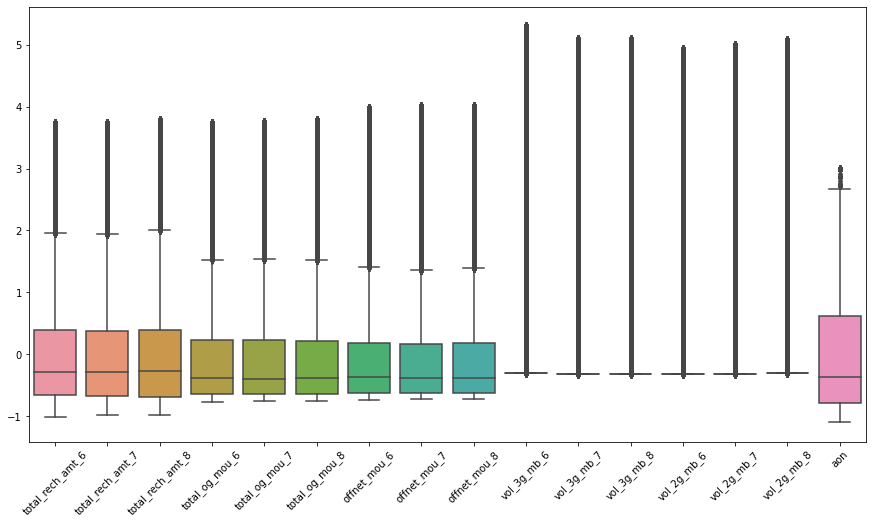

In [24]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = pd.DataFrame(X_train_filtered2, columns=new_vars))

<AxesSubplot:>

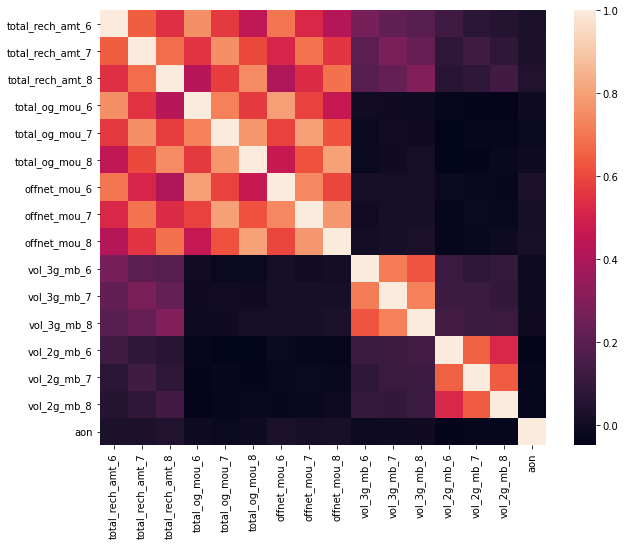

In [25]:
plt.figure(figsize=(10,8))
sns.heatmap(pd.DataFrame(X_train_filtered2, columns=new_vars).corr())

<AxesSubplot:xlabel='churn_probability', ylabel='Count'>

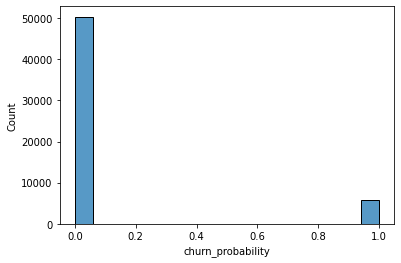

In [26]:
#Distribution for the churn probability
sns.histplot(y_train)

# 5. Feature engineering and selection
Let's understand feature importances for raw features as well as components to decide top features for modelling.

Feature selection using Random forest comes under the category of Embedded methods. Embedded methods combine the qualities of filter and wrapper methods. They are implemented by algorithms that have their own built-in feature selection methods. Some of the benefits of embedded methods are :
* They are highly accurate.
* They generalize better.
* They are interpretable

In [27]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(X_train_filtered2, y_train)

RandomForestClassifier(n_jobs=-1)

In [28]:
feature_importances = pd.DataFrame({'col':new_vars, 'importance':rf.feature_importances_})
feature_importances.sort_values('importance',ascending=False)

,col,importance
5,total_og_mou_8,0.227752
8,offnet_mou_8,0.127872
2,total_rech_amt_8,0.096434
15,aon,0.075548
4,total_og_mou_7,0.067766
7,offnet_mou_7,0.066740
3,total_og_mou_6,0.061600
6,offnet_mou_6,0.060603
0,total_rech_amt_6,0.055112
1,total_rech_amt_7,0.054740


<BarContainer object of 16 artists>

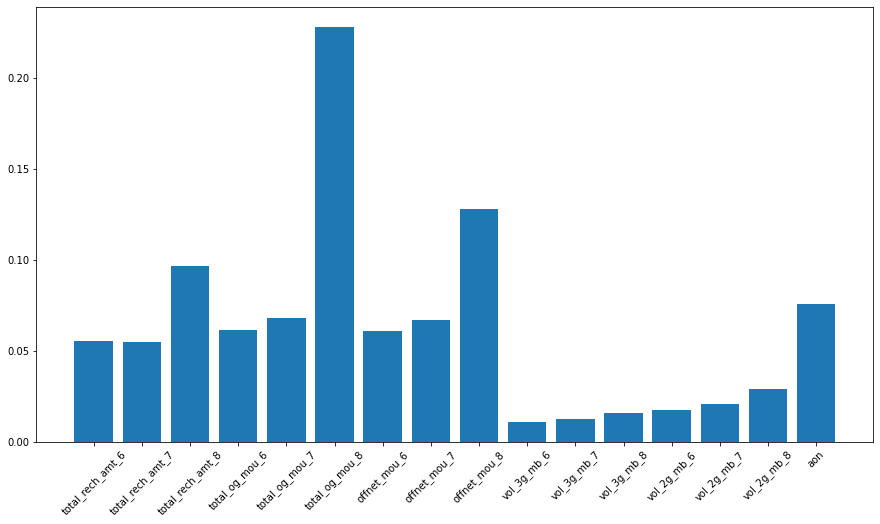

In [29]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

At this step, we can create a bunch of features based on business understanding, such as

"average % gain of 3g volume from month 6 to 8" - (growth or decline of 3g usage month over month?)
"ratio of total outgoing amount and age of user on network" - (average daily usage of a user?)
"standard deviation of the total amount paid by user for all services" - (too much variability in charges?)
etc..
Another way of finding good features would be to project them into a lower dimensional space using PCA. PCA creates components which are a linear combination of the features. This then allows you to select components which explain the highest amount of variance.


<AxesSubplot:>

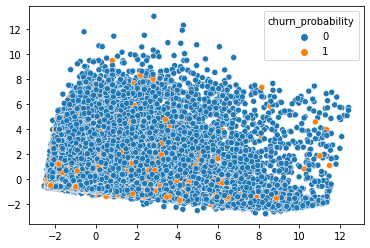

In [30]:
pca = PCA()
pca_components = pca.fit_transform(X_train_filtered2)
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y_train)

<AxesSubplot:>

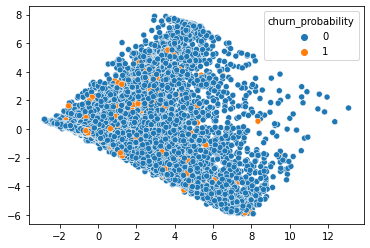

In [31]:
sns.scatterplot(x=pca_components[:,1], y=pca_components[:,2], hue=y_train)

Let's also check which of the components have high feature importances towards the end goal of churn prediction.

<BarContainer object of 16 artists>

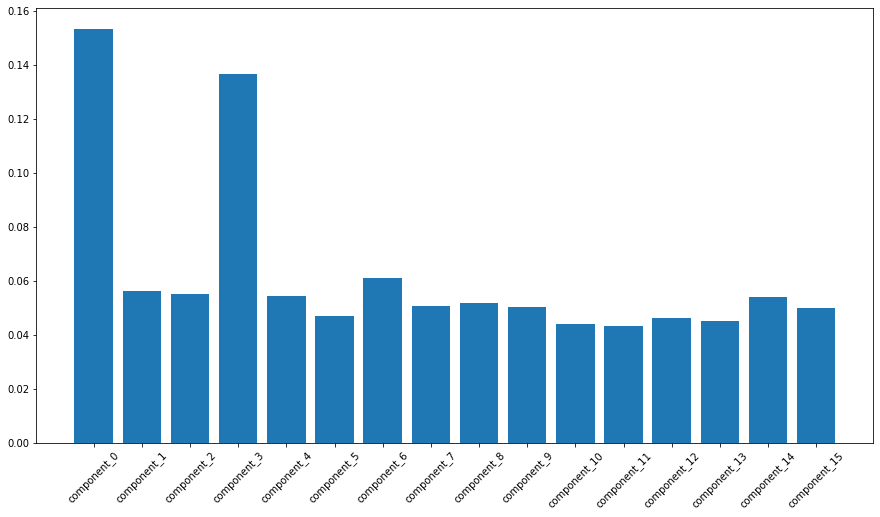

In [32]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=100)
rf.fit(pca_components, y_train)

feature_importances = pd.DataFrame({'col':['component_'+str(i) for i in range(16)], 
                                    'importance':rf.feature_importances_})

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

# 6. Model building
Let's build a quick model with logistic regression and the first 2 PCA components.

In [33]:
lr = LogisticRegression(max_iter=1000, tol=0.001, solver='sag')
lr.fit(pca_components[:,:2], y_train)

LogisticRegression(max_iter=1000, solver='sag', tol=0.001)

In [34]:
lr.score(pca_components[:,:2], y_train)

0.8984624725441526

The model has 89.8% accuracy, but let's build a pipeline to fit and score the model faster.

The steps of this pipeline would be the following, but this is only one type of pipeline -

- Imputation
- Scaling
- PCA
- Classification model

We can change this pipeline, add addition transformations, change models, use cross validation or even use this pipeline to work with a Gridsearch.

In [35]:
imp = SimpleImputer(strategy='constant', fill_value=0)
scale = StandardScaler()
pca = PCA(n_components=10)
lr = LogisticRegression(max_iter=1000, tol=0.001)
pipe = Pipeline(steps = [('imputation',imp),
                         ('scaling',scale),
                         ('pca',pca),
                         ('model',lr)])

In [36]:
pipe.fit(X_train[new_vars], y_train)

Pipeline(steps=[('imputation',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('scaling', StandardScaler()), ('pca', PCA(n_components=10)),
                ('model', LogisticRegression(max_iter=1000, tol=0.001))])

In [37]:
train_score = pipe.score(X_train[new_vars], y_train)
print("Training accuracy:", train_score)

Training accuracy: 0.9005696530295184


In [38]:
test_score = pipe.score(X_test[new_vars], y_test)
print("Test accuracy:", test_score)

Test accuracy: 0.8973571428571429


In [39]:
## Let's make a confusion matrix to analyze how each class is being predicted by the model.

confusion_matrix(y_train, pipe.predict(X_train[new_vars]))

array([[50044,   269],
       [ 5299,   387]], dtype=int64)

In [40]:
confusion_matrix(y_test, pipe.predict(X_test[new_vars]))

array([[12472,    82],
       [ 1355,    91]], dtype=int64)

In [41]:
precision_score(y_test, pipe.predict(X_test[new_vars]))

0.5260115606936416

In [42]:
recall_score(y_test, pipe.predict(X_test[new_vars]))

0.06293222683264177

In [43]:
imp2 = SimpleImputer( strategy="mean")
scale2 = StandardScaler()
pca2= PCA()
rfc = RandomForestClassifier()
pipe2 = Pipeline(steps = [('imputation',imp2),
                         ('scaling',scale2),
                         ('pca',pca2),
                         ('model2',rfc)])
params2 = [{'pca__n_components': [10, 12, 16],'model2__n_estimators':[150,180,200],
           'model2__random_state':[100],'model2__n_jobs':[-1],'model2__min_samples_split': [2,5,10,20]}]

In [44]:
gs_rfc = GridSearchCV(pipe2,
                      param_grid=params2,
                      scoring='accuracy',
                      cv=5)
gs_rfc.fit(X_train[new_vars], y_train)
gs_rfc.best_params_

{'model2__min_samples_split': 5,
 'model2__n_estimators': 180,
 'model2__n_jobs': -1,
 'model2__random_state': 100,
 'pca__n_components': 16}

In [45]:
gs_rfc.best_score_

0.92662371161966

In [46]:
gs_rfc.score(X_train[new_vars], y_train)
print("Training accuracy:", train_score)

Training accuracy: 0.9005696530295184


In [47]:
gs_rfc.score(X_test[new_vars], y_test)
print("Test accuracy:", test_score)

Test accuracy: 0.8973571428571429


In [48]:
## Let's make a confusion matrix to analyze how each class is being predicted by the model.

confusion_matrix(y_train, gs_rfc.predict(X_train[new_vars]))

array([[50304,     9],
       [  209,  5477]], dtype=int64)

In [49]:
confusion_matrix(y_test, gs_rfc.predict(X_test[new_vars]))

array([[12442,   112],
       [  903,   543]], dtype=int64)

In [50]:
precision_score(y_test, gs_rfc.predict(X_test[new_vars]))

0.8290076335877863

In [51]:
recall_score(y_test, gs_rfc.predict(X_test[new_vars]))

0.3755186721991701

# 7. Creating submission file¶
For submission, we need to make sure that the format is exactly the same as the sample.csv file. It contains 2 columns, id and churn_probability

In [52]:
sample.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


In [53]:
unseen.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,...,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,...,0,0,0,NaN,NaN,NaN,2533,0.00,0.00,0.00
2,70001,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,329.844,434.884,...,0,0,0,NaN,NaN,NaN,277,525.61,758.41,241.84
3,70002,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,43.550,171.390,...,0,0,0,NaN,NaN,NaN,1244,0.00,0.00,0.00
4,70003,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,306.854,406.289,...,0,0,0,NaN,NaN,NaN,462,0.00,0.00,0.00


Lets first select the columns that we want to work with feature engineering

In [54]:
submission_data = unseen.set_index('id')[new_vars]
submission_data.shape


(30000, 16)

Next, lets create a new column in the unseen dataset called churn_probability and use the model pipeline to predict the probabilities for this data

In [55]:
unseen['churn_probability'] = gs_rfc.predict(submission_data)
output = unseen[['id','churn_probability']]
output.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


In [56]:
#Finally, lets create a csv file out of this dataset

output.to_csv('Submission.csv',index=False)

